In [1]:
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadFromDisk, SaveToDisk, EOExecutor
from eolearn.io import S2L1CWCSInput, S1IWWCSInput, ExportToTiff
from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam
import os
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from shapely.geometry import Polygon


In [2]:
import arcpy

In [1]:
DATA_FOLDER = 'C:\data\S1_test'
LOGS_FOLDER = os.path.join(DATA_FOLDER, 'logs')
if not os.path.isdir(LOGS_FOLDER):
    os.makedirs(LOGS_FOLDER)
    
#custom_script = 'return [B02, B03, B04, B08, B11, B12];'
custom_script = 'return [B02, B03, B04, B05, B06, B07, B08A, B08, B11, B12];'
add_data = S2L1CWCSInput(
    layer='BANDS-S2-L1C', 
    feature=(FeatureType.DATA, 'BANDS'), # save under name 'BANDS'
    custom_url_params={CustomUrlParam.EVALSCRIPT: custom_script}, # custom url for 6 specific bands
    resx='10m', # resolution x
    resy='10m', # resolution y
    maxcc=0.8, # maximum allowed cloud cover of original ESA tiles
)

# TASK FOR SAVING TO OUTPUT (if needed)
path_out = os.path.join(DATA_FOLDER, 'eopatches')
if not os.path.isdir(path_out):
    os.makedirs(path_out)
save = SaveToDisk(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)


# Define the workflow
workflow = LinearWorkflow(
    add_data,
    save
)

# Let's visualize it
workflow.dependency_graph()

NameError: name 'os' is not defined

In [8]:
area = gpd.read_file(os.path.join(DATA_FOLDER, 'Drummond.geojson'))
# Convert CRS to UTM_18N
area_crs = CRS.UTM_18N
area = area.to_crs(crs={'init': CRS.ogc_string(area_crs)})
# Get the area shape in polygon format
area_shape = area.geometry.values.tolist()[-1]

bbox_splitter = BBoxSplitter([area_shape], area_crs, (7, 5))
bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# Prepare info of selected EOPatches
#geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list]

geometry = bbox_list[0].geometry

In [9]:
%%time

# Execute the workflow
time_interval = ['2017-01-01', '2017-12-31'] # time interval for the SH request

# define additional parameters of the workflow
execution_args = []
# for idx, bbox in enumerate(bbox_list[patchIDs]):
#     execution_args.append({
#         add_data:{'bbox': bbox, 'time_interval': time_interval},
#         save: {'eopatch_folder': 'eopatch_{}'.format(idx)}
#     })
idx = 0  # bbox to download 
execution_args = [{
        add_data:{'bbox': bbox_list[idx], 'time_interval': time_interval},
        save: {'eopatch_folder': 'eopatch_{}'.format(idx)},
    }]
executor = EOExecutor(workflow, execution_args, save_logs=True, logs_folder=LOGS_FOLDER)
executor.run(workers=5, multiprocess=False)

executor.make_report()


Wall time: 48.9 s


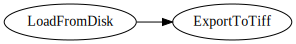

In [5]:
# TASK TO LOAD EXISTING EOPATCHES
load = LoadFromDisk(path_out)

# TASK FOR SAVING
save = SaveToDisk(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

# TASK TO EXPORT TIFF
export_tiff = ExportToTiff((FeatureType.DATA, 'BANDS'), band_indices=(0,5), date_indices=[1])
tiff_location = os.path.join(DATA_FOLDER, 'tiff')
if not os.path.isdir(tiff_location):
    os.makedirs(tiff_location)
    
    
workflow2 = LinearWorkflow(
    load,
    export_tiff
)
workflow2.dependency_graph()

In [6]:
# create a list of execution arguments for each patch
# execution_args = []
# for i in range(len(patchIDs)):
#     execution_args.append(
#         {
#             load: {'eopatch_folder': 'eopatch_{}'.format(i)},
#             export_tiff: {'filename': '{}/prediction_eopatch_{}.tiff'.format(tiff_location, i)},
#             save: {'eopatch_folder': 'eopatch_{}'.format(i)}
#         }
#     )
execution_args = [{
            load: {'eopatch_folder': 'eopatch_0'},
            export_tiff: {'filename': '{}/eopatch.tiff'.format(tiff_location)}
        }]
# run the executor on 2 cores
executor = EOExecutor(workflow2, execution_args)

# uncomment below save the logs in the current directory and produce a report!
#executor = EOExecutor(workflow, execution_args, save_logs=True)

executor.run(workers=2, multiprocess=False)
executor.make_report()

In [2]:
import numpy as np
# data_array1 = np.load('C:\data\S1_test\eopatches\eopatch_0\data\BANDS.npy')
# data_array2 = np.load('C:\data\S1_test\eopatches\eopatch_0\mask\IS_DATA.npy')
# data_array_scr = np.load('C:\data\crop\eopatches_sampled\eopatch_0\data_timeless\SCR_GBM.npy')
# data_array_mask = np.load('C:\data\crop\eopatches_sampled\eopatch_0\mask_timeless\LULC.npy')
eopatches_sampled = np.load('C:\data\predict\eopatches_sampled\eopatch_0\data\FEATURES.npy')
#eopatches_sampled2 = np.load('C:\data\crop\eopatches_sampled\eopatch_4\data\FEATURES.npy')
# eopatches_sampled3 = np.load('N:\CropInventoryAutomation\crop_large\eopatches_sampled\eopatch_1\data\FEATURES_SAMPLED.npy')
#eopatches_sampled4 = np.load('N:\CropInventoryAutomation\crop_large\eopatches\eopatch_1\data\BANDS.npy')
# print(type(data_array1))
# print(data_array1.shape)
# print(data_array2.shape)
# print(data_array2)

print(eopatches_sampled.shape)
#print(eopatches_sampled2.shape)
# print(eopatches_sampled3.shape)
# print(eopatches_sampled4.shape)


(23, 210, 526, 13)


In [11]:
print(int(2e5))
print(type(2e5))
print(1e5)

200000
<class 'float'>
100000.0


In [3]:


#fig = plt.figure(figsize=(20, 20))


timeframe = 15
# for i in range(49):
#     eopatch = EOPatch.load('{}\eopatch_{}'.format(path_out, i), lazy_loading=True)

eopatch = EOPatch.load('C:\data\predict\eopatches\eopatch_3', lazy_loading=True)
###ax = plt.subplot(7, 7, i + 1)
# plt.imshow(np.clip(eopatch.data['BANDS'][timeframe][..., [2, 1, 0]] * 3.5, 0, 1))
# plt.imshow(np.clip(eopatch.data['BANDS'][timeframe][..., [7,7,7]] * 3.5, 0, 1))
# plt.xticks([])
# plt.yticks([])

# print(eopatch.timestamp[timeframe])
# del eopatch

# fig.subplots_adjust(wspace=0, hspace=0)

print(eopatch)


ImportError: cannot import name 'EOPatchVisualization'

In [7]:
train_ID = list(range(0, 49))
test_ID = [20, 21, 22, 23, 24]
for i in test_ID:
    train_ID.remove(i)
print(train_ID)
#test_ID = [x for x in range(49) if x not in train_ID] 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
